**Penjelasan singkat mengenai pipeline implementasi**

Penyelesaian kasus Spam Filtering yang dibuat menggunakan metode ensemble learning. Secara sederhana, ensemble learning menggunakan lebih dari satu algoritma klasifikasi (dalam kasus ini LSTM, DNN, dan SVM) untuk melakukan prediksi suatu kelas. Ada beberapa pendekatan yang bisa dilakukan untuk mendapatkan kelasnya, yang digunakan saat ini adalah metode voting, dimana kelas yang paling sering muncul dari ketiga algoritma tersebut yang akan diambil.


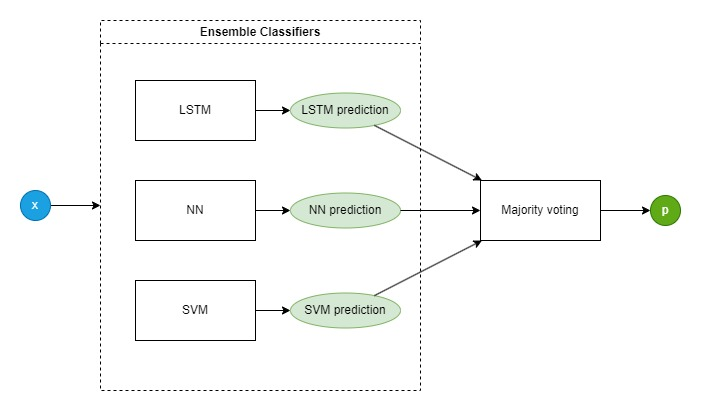

**Pipeline**

1. Dataset dibagi menjadi 2 bagian, pertama data latih yang digunakan untuk initial train model, kedua data test yang terdiri dari isi email saja tanpa kelas dan dibagi menjadi beberapa bagian. Data test ini nantinya digunakan dalam proses incremental learning model ensemble.
2. Preprocessing data: dilakukan data cleansing dan vectorization kata
3. Proses training model dilakukan dengan cara melakukan training pada seluruh algoritma klasifikasi yang menyusun ensemble learning.
4. Proses prediksi, sebagaimana dijelaskan di atas, dilakukan dengan cara voting terhadap kelas terbanyak yang muncul dari algoritma-algoritma yang menyusun ensemble learning. Setelah didapatkan kelasnya, data ini digabungkan dengan data latih sebelumnya yang kemudian digunakan dalam melatih model kembali.
5. Proses training dan prediksi dilakukan terus menerus hingga tidak ada data yang bisa diprediksi lagi.

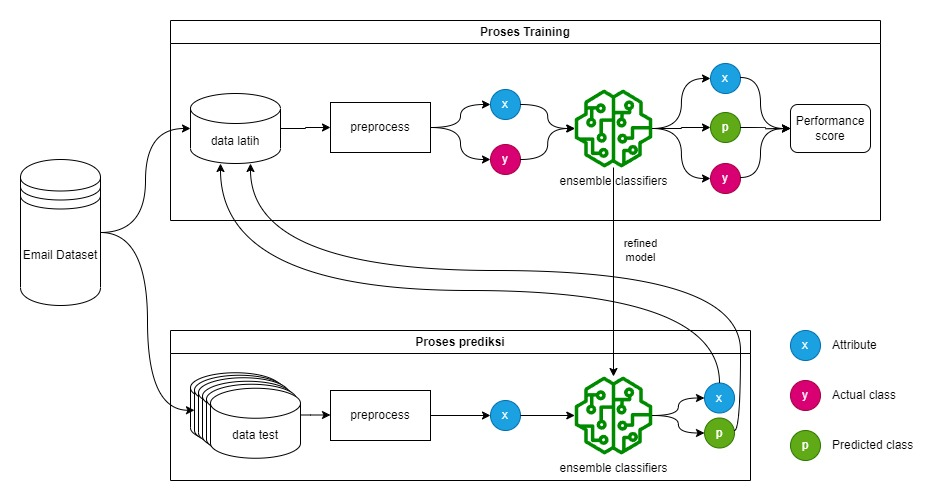

# Dependencies

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from river.feature_extraction import TFIDF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
from scipy.stats import mode
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from river.tree import ExtremelyFastDecisionTreeClassifier
from river import stream

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fauzan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fauzan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Split train & test

Bagian ini digunakan untuk membagi dataset menjadi 2 bagian

# Read data

Bagian ini digunakan untuk melakukan import dataset serta menyesuaikan nama dan tipe kolom

## SMS

https://lazyprogrammer.me/course_files/spam.csv

In [39]:
df = pd.read_csv('../../Datasets/SMS/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [40]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
df['label'] = df['label'].map({'ham' : 0, 'spam' : 1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## EnronSpam

Dataset ini didapat dari (http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html). Berisi beragam email dengan perbandingan yang hampir sama (50:50).

note: dataset yang diimport ke colab ini sudah dilakukan parsing ke csv. Hasilnya bisa didownload di [sini](https://drive.google.com/drive/folders/1s5GNI1f6JS6DafSTPzSkI6DOwjtpUxng?usp=drive_link)



In [1]:
df_raw = pd.DataFrame()

for i in range(1,7):
  temp = pd.read_csv('../../Datasets/EnronSpam/parsed/EnronSpam{}.csv'.format(i))
  df_raw = pd.concat([df_raw, temp], ignore_index=True)

df_raw.rename(columns={'email': 'text'}, inplace=True)
df_raw

,text,label
0,Subject: eastrans nomination change effective ...,0
1,Subject: re : personal information needs to be...,0
2,Subject: re : saudi arabia\r\ni spoke to mr . ...,0
3,"Subject: hpl nom for may 24 , 2001\r\n( see at...",0
4,"Subject: re : error repairs\r\njay ,\r\nfor ju...",0
...,...,...
33711,Subject: ` shoot bucket loads of sperm\r\nlncr...,1
33712,"Subject: ' the antidote '\r\nhello ,\r\nwe hav...",1
33713,Subject: we have top - selling rxdrugs for you...,1
33714,Subject: re : thhe problem solved\r\ndear sir ...,1


In [2]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33716 entries, 0 to 33715
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33716 non-null  object
 1   label   33716 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 526.9+ KB


In [3]:
df_raw['label'].value_counts(normalize=True)

label
1    0.509283
0    0.490717
Name: proportion, dtype: float64

### Adjust distribution

Karena distribusi 50:50 tidak realistis, maka dataset direkayasa agar jumlah non-spam lebih banyak daripada spam

In [4]:
label0 = df_raw[df_raw['label'] == 0]
label1 = df_raw[df_raw['label'] == 1].sample(frac=0.3, random_state=42)

In [5]:
df = pd.concat([label0, label1], ignore_index=True)
df['label'].value_counts(normalize=True)

label
0    0.762583
1    0.237417
Name: proportion, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21696 entries, 0 to 21695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21696 non-null  object
 1   label   21696 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 339.1+ KB


### Split train & test

Bagian ini digunakan untuk membagi dataset menjadi 3 bagian masing-masing 70:30:10

In [7]:
data_train, data_test_val = train_test_split(df, stratify=df['label'], train_size=0.7, random_state=42)
data_train.reset_index(inplace=True, drop=True)
data_test_val.reset_index(inplace=True, drop=True)
data_test, data_val = train_test_split(data_test_val, stratify=data_test_val['label'], train_size=0.66, random_state=42)
data_test.reset_index(inplace=True, drop=True)
data_val.reset_index(inplace=True, drop=True)

In [8]:
print('Data train size: {}'.format(len(data_train.index)))
print('Data test size: {}'.format(len(data_test.index)))
print('Data val size: {}'.format(len(data_val.index)))

Data train size: 15187
Data test size: 4295
Data val size: 2214


In [10]:
data_train.to_csv('../../Datasets/EnronSpam/parsed/split/train.csv', index=False)
data_test.to_csv('../../Datasets/EnronSpam/parsed/split/test.csv', index=False)
data_val.to_csv('../../Datasets/EnronSpam/parsed/split/val.csv', index=False)

# Preprocess

## Clean text

Proses cleansing yang telah dilakukan antara lain menghilangkan angka, lowercase, menghilangkan newline character (\r\n), menghapus stopwords (stopwords didapatkan dari corpus NLTK), stemming menggunakan SnowballStemmer. Hasil akhir setelah cleansing berupa string.

In [2]:
class DatasetUtils:
  def __init__(self, dataset: pd.DataFrame, name):
    self.dataset = dataset
    self.name = name

  def get_column_values(self, col_name):
    return self.dataset[col_name].values

  def _remove_non_printable_char(self, text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

  def _remove_punctuation(self, text):
    return text.translate(str.maketrans('', '', string.punctuation))

  def _remove_number(self, text):
    return text.translate(str.maketrans('', '', string.digits))

  def _remove_stopword(self, tokens):
    stop_words = set(stopwords.words('english'))
    clean_tokens = []
    for token in tokens:
      if token not in stop_words:
        clean_tokens.append(token)
    return clean_tokens

  def _stem(self, tokens):
    stemmer = EnglishStemmer()
    stemmed = [stemmer.stem(token) for token in tokens]
    return stemmed

  def _remove_new_line_character(self, tokens):
    res = []
    for token in tokens:
      res.append(token.replace('\r\n', ''))
    return res

  def _preprocess_each_row(self, text):
    text = self._remove_non_printable_char(text)
    text = self._remove_number(text)
    text = text.lower()
    text = self._remove_punctuation(text)
    tokens = word_tokenize(text)
    tokens = self._remove_stopword(tokens)
    tokens = self._stem(tokens)
    result = " ".join(tokens).strip()
    return result
  
  def preprocess(self):
    self.dataset['preprocessed'] = self.dataset['text'].apply(self._preprocess_each_row)
    self.dataset.dropna(inplace=True)
    print('Finished preprocessing {} data'.format(self.name).center(30, '-'))

### Unused

In [60]:
text_per_row_length = df['text'].apply(len)

max_seq_len = int(np.percentile(text_per_row_length.values, 95))

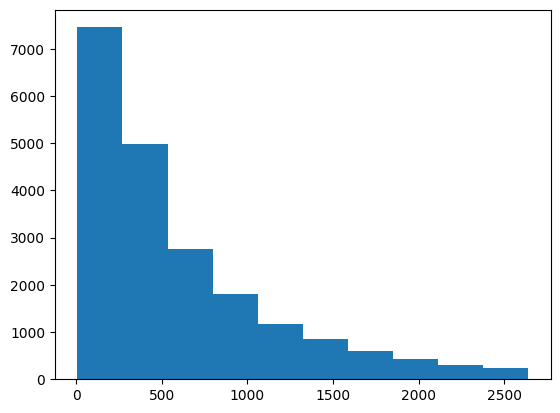

In [61]:
from matplotlib import pyplot as plt

plt.hist(text_per_row_length[text_per_row_length < max_seq_len])
plt.show()

# Feature extraction


## TF-IDF

In [4]:
class Vectorizer: # ini yang pake river
  def __init__(self):
    self.vectorizer = TFIDF()
    self.vocab_size = None

  def adapt(self, X):
    for sentence in X:
      self.vectorizer = self.vectorizer.learn_one(sentence)
    self.vocab_size = len(self.vectorizer.dfs)

  def transform(self, X):
    result = []
    for row in X:
      raw_vector = self.vectorizer.transform_one(row)
      full_vector = {}
      for word in self.vectorizer.dfs.keys(): # cek semua vocab
        value = 0
        if word in raw_vector.keys():
          value = raw_vector[word]
        full_vector[word] = value
      result.append(full_vector)

    return result

In [3]:
class Vectorizer: # pake tensorflow
  def __init__(self):
    self.vectorizer = tf.keras.layers.TextVectorization(
      output_mode='tf_idf'
    )
    self.vocab_size = None

  def adapt(self, X):
    self.__init__()
    self.vectorizer.adapt(X)
    self.vocab_size = self.vectorizer.vocabulary_size()

  def transform(self, X):
    tfidf_res = self.vectorizer(X).numpy()
    result = [dict(zip(self.vectorizer.get_vocabulary(), row)) for row in tfidf_res]

    return result

# Classes

In [4]:
class TensorIncrementalClassifier:
  def __init__(self):
    self.es = tf.keras.callbacks.EarlyStopping(
      monitor='precision', patience=3, mode='max', restore_best_weights=True
    )
    self.base_layers = []
    self.weights = None
    self.model = None
  
  def create_model(self, input_dim):
    embedding_layer = tf.keras.layers.Embedding(
      input_dim,
      output_dim=64,
      # mask_zero=True
    )
    model = tf.keras.Sequential([embedding_layer])
    for layer in self.base_layers:
      model.add(layer)
    
    model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
      ]
    )
    
    return model
    
  def save_weight(self):
    self.weights = self.model.get_weights()

  def update(self, input_dim, X_train, y_train):
    self.save_weight()
    self.model = self.create_model(input_dim)
    self.model.set_weights(self.weights)
    self.model.fit(
      X_train, y_train, epochs=100, callbacks=[self.es]
    )

  def fit(self, X_train, y_train, X_test, y_test):
    self.model.fit(
      X_train, y_train, 
      epochs=100, 
      validation_data=(X_test, y_test), 
      callbacks=[self.es]
    )

  def predict(self, X):
    return self.model.predict(X)

In [5]:
class TensorFlowAdapter: # Kelas yang digunakan sebagai adapter untuk algoritma yang diimplementasi dari tensorflow
  def __init__(self, model: TensorIncrementalClassifier, name):
    self.model = model
    self.name = name

  def predict(self, X):
    X = self.__extract_value(X)
    return self.model.predict(X).flatten()
  
  def __extract_value(self, X):
    return np.array([list(row.values()) for row in X])

  def fit(self, X_train, y_train, X_test, y_test):
    X_train = self.__extract_value(X_train)
    X_test = self.__extract_value(X_test)
    self.model.fit(X_train, y_train, X_test, y_test)
    
  def update(self, input_dim, X_train, y_train):
    X_train = self.__extract_value(X_train)
    self.model.update(input_dim, X_train, y_train)

In [6]:
class RiverMLAdapter: # Kelas yang digunakan sebagai adapter untuk algoritma yang diimplementasi dari sklearn
  def __init__(self, model, name):
    self.model = model
    self.name = name

  def predict(self, X):
    result = []
    for i in X:
      result.append(self.model.predict_proba_one(i)[1])

    return result

  def fit(self, X_train, y_train, X_test, y_test):
    for X, y in zip(X_train, y_train):
      self.model = self.model.learn_one(X, y)

  def update(self, X, y):
    self.model = self.model.learn_one(X, y)
  

In [7]:
class SpamClassifier: # Kelas utama yang menampung ensemble classifier
  def __init__(self, classifiers):
    self.classifiers = classifiers # Variabel yang menampung algoritma-algoritma klasifikasi

    self.prediction_threshold = 0.5 # Threshold dalam menentukan kelas spam (> 0.5 berarti spam)
    self.evaluation = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1']) # Menampung history score tiap model sejauh iterasi

  def __train_classifiers(self, X_train, X_test, y_train, y_test): # Method yang digunakan untuk melakukan train semua classifiers yang menyusun ensemble classifier
    for index in range(len(self.classifiers)):
      print(' Train {} model '.format(self.classifiers[index].name).center(30, '+'))
      self.classifiers[index].fit(X_train, y_train, X_test, y_test)

  def train(self, X_train, X_test, y_train, y_test):
    self.__train_classifiers(X_train, X_test, y_train, y_test)

  def __update_classifiers(self, X, y):
    for index in range(len(self.classifiers)):
      print(' Update {} model '.format(self.classifiers[index].name).center(30, '+'))
      self.classifiers[index].update(X, y)

  def update(self, X, y):
    self.__update_classifiers(X, y)

  def __evaluate_model(self, y_true, prediction): # Method yang digunakan untuk mengambil evaluasi tiap model
    modelName = ''
    for classifier in self.classifiers:
      modelName += classifier.name + ' '

    print(' Evaluate {} model '.format(modelName).center(30, '+'))

    accuracy = accuracy_score(y_true, prediction)
    precision = precision_score(y_true, prediction)
    recall = recall_score(y_true, prediction)
    f1 = f1_score(y_true, prediction)

    print('Accuracy: {} | Precision: {} | Recall: {} | F1: {}'.format(accuracy, precision, recall, f1))
    curr_eval = pd.Series({'Model': modelName, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1})
    self.evaluation = pd.concat([self.evaluation, curr_eval.to_frame().T], ignore_index=True)

  def evaluate(self, y_true, prediction):
    self.__evaluate_model(y_true, prediction)

  def __predict(self, X): # Method yang digunakan untuk mendapatkan kelas prediksi
    raw_predictions = []
    for index in range(len(self.classifiers)):
      print(' Predicting using {} model '.format(self.classifiers[index].name).center(30, '-'))
      temp = self.classifiers[index].predict(X)
      temp[temp <= self.prediction_threshold] = 0
      temp[temp > self.prediction_threshold] = 1
      raw_predictions.append(temp)

    raw_predictions = np.stack((raw_predictions), axis=1)
    result = mode(raw_predictions, axis=-1, keepdims=False)
    return result.mode

  def get_prediction(self, X):
    return self.__predict(X)

# Skenario

In [8]:
def plot_confusion_matrix(y_true, prediction): # Method untuk menggambar confusion matrix
  cm = confusion_matrix(y_true, prediction)
  ConfusionMatrixDisplay(cm, display_labels=['false' ,'true']).plot()
  plt.title('Confusion Matrix')
  plt.show()
  # plt.savefig('evaluation/confusion_matrix/iteration_{}.png'.format(iteration))

In [10]:
def plot_graphs(metric, eval):
  plt.title(metric)
  for key in eval.keys():
    plt.plot(eval[key][metric])
  plt.xlabel('Iteration')
  plt.ylabel('Score')
  plt.legend(eval.keys())
  plt.show()

## Ensemble

### Model Initialization

#### LSTM

In [11]:
class LSTM(TensorIncrementalClassifier):
  def __init__(self, input_dim):
    super().__init__()
    self.base_layers = [
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ]
    self.model = self.create_model(input_dim)

  def create_model(self, input_dim):
    return super().create_model(input_dim)

#### DNN

In [12]:
class DNN(TensorIncrementalClassifier):
  def __init__(self, input_dim):
    super().__init__()
    self.base_layers = [
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ]
    self.model = self.create_model(input_dim)

  def create_model(self, input_dim):
    return super().create_model(input_dim)

#### DecisionTree

### Execution

#### Initial Learning

In [16]:
datasetUtils = DatasetUtils(data_train, data_to_predict)
vectorizer = VectorizerWrapper()
X_train, X_test, y_train, y_test = datasetUtils.split_data()

print(' Inital Train '.center(40, '#'))

vectorizer.adapt(X_train)

print(' Vectorize data '.center(40, '-'))

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

############# Inital Train #############
------------ Vectorize data ------------


In [17]:
spamClassifier = SpamClassifier([
  TensorFlowAdapter(LSTM(vectorizer.vocab_size), 'LSTM'),
  TensorFlowAdapter(DNN(vectorizer.vocab_size), 'DNN'),
  RiverMLAdapter(ExtremelyFastDecisionTreeClassifier(), 'Decision Tree')
])

print(' Train data '.center(40, '-'))
spamClassifier.train(X_train, X_test, y_train, y_test)

print(' Evaluate models '.center(30, '-'))
spamClassifier.evaluate(X_test, y_test)

plot_confusion_matrix(X_test, y_test, spamClassifier)

-------------- Train data --------------
++++++ Train LSTM model ++++++
Epoch 1/100
61/61 [==============================] - 151s 2s/step - loss: 0.4494 - accuracy: 0.8532 - precision: 0.1250 - recall: 0.0153 - val_loss: 0.3968 - val_accuracy: 0.8659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
61/61 [==============================] - 147s 2s/step - loss: 0.3958 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3984 - val_accuracy: 0.8659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
61/61 [==============================] - 151s 2s/step - loss: 0.3946 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3955 - val_accuracy: 0.8659 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
61/61 [==============================] - 143s 2s/step - loss: 0.3962 - accuracy: 0.8655 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3961 - val_accuracy: 0.8659 - val_precision: 0.0000e+00 -

TypeError: list indices must be integers or slices, not str

#### Incremental Learning

In [ ]:
print(' Processing datastream '.center(40, '#'))
data_predict_used = 0

for X, y in stream.iter_pandas(datasetUtils.get_data_to_predict()):
  X_vect = vectorizer.transform(X)
  print(' Get prediction '.center(40, '-'))
  prediction = spamClassifier.get_prediction(X_vect)
  print('Predicted label: {} | Real label: {}'.format(prediction, y))
  datasetUtils.add_predicted_data(X, y, prediction)

  if prediction != y:
    data_predict_used += 1
    print(' Update models '.center(30, '-'))
    spamClassifier.update(X_train, X_test)
    vectorizer.adapt([X])

print('Sample used = {}'.format(data_predict_used/len(datasetUtils.data_to_predict)).center(30, '#'))

## Single

### Initial Train

In [9]:
data_train = pd.read_csv('../../Datasets/EnronSpam/parsed/split/train.csv')
data_val = pd.read_csv('../../Datasets/EnronSpam/parsed/split/val.csv')

In [10]:
data_train = DatasetUtils(data_train, 'Data Train')
data_val = DatasetUtils(data_val, 'Data Validation')

In [11]:
data_train.preprocess()
data_val.preprocess()

Finished preprocessing Data Train data
Finished preprocessing Data Validation data


In [34]:
text_vectorizer = Vectorizer()

In [35]:
X_train = data_train.get_column_values('preprocessed')
text_vectorizer.adapt(X_train)

In [36]:
X_train = text_vectorizer.transform(X_train)

In [ ]:
X_train[0]

In [13]:
X_train = data_train.get_column_values('preprocessed')

text_vectorizer = tf.keras.layers.TextVectorization(
  output_mode='tf_idf'
)
text_vectorizer.adapt(X_train)
X_train = text_vectorizer(X_train)

In [20]:
X_val = data_val.get_column_values('preprocessed')
X_val = text_vectorizer.transform(X_val)

In [15]:
X_val = data_val.get_column_values('preprocessed')
X_val = text_vectorizer(X_val)

In [16]:
y_train = data_train.get_column_values('label')
y_val = data_val.get_column_values('label')

In [20]:
classifiers = [
  # TensorFlowAdapter(LSTM(text_vectorizer.vocab_size), 'LSTM'),
  # TensorFlowAdapter(DNN(text_vectorizer.vocab_size), 'DNN'),
  RiverMLAdapter(ExtremelyFastDecisionTreeClassifier(), 'Decision Tree')
]

MemoryError: Unable to allocate 5.72 MiB for an array with shape (62454,) and data type <U24

In [18]:
for classifier in classifiers:
  spamClassifier = SpamClassifier([classifier])

  print(' Train data '.center(40, '-'))
  spamClassifier.train(X_train, X_val, y_train, y_val)

  print(' Evaluate models '.center(30, '-'))
  prediction = spamClassifier.get_prediction(X_val)
  spamClassifier.evaluate(y_val, prediction)

  plot_confusion_matrix(y_val, prediction)

-------------- Train data --------------
+ Train Decision Tree model ++


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'items'

### Export Model, dan Result

In [ ]:
resultDir = '../../Result'
learningMethod = 'SingleLearning'
vectorMethod = 'tfiidf'
experiment = '2'

finalDir = resultDir + '/' + learningMethod + '/' + vectorMethod + '/' + experiment + '/'

### Unused

In [ ]:
resultDir = '../../Result'
learningMethod = 'SingleLearning'
vectorMethod = 'tfiidf'
experiment = '2'

finalDir = resultDir + '/' + learningMethod + '/' + vectorMethod + '/' + experiment + '/'

for classifier in classifiers:
  print(' {} '.format(classifier.name).center(40, '~'))
  datasetUtils = DatasetUtils(data_train, data_to_predict)
  vectorizer = VectorizerWrapper()
  X_train, X_test, y_train, y_test = datasetUtils.split_data()

  print(' Inital Train '.center(40, '#'))

  vectorizer.adapt(X_train)

  print(' Vectorize data '.center(40, '-'))

  X_train = vectorizer.transform(X_train)
  X_test = vectorizer.transform(X_test)
  # model_eval = {}
  # for model in evaluation['Model'].values:
  #   model_eval[model] = evaluation[evaluation['Model'] == model].reset_index() 
  #   try:
  #     os.makedirs(finalDir)
  #   except FileExistsError:
  #     # model_eval[model].to_csv(finalDir + '{}_score.csv'.format(model))
  #     evaluation.to_csv(finalDir + '{}_score.csv'.format(model), index=False)
  #     predictedDataset.to_csv(finalDir + '{}_predicted_dataset.csv'.format(model), index=False)

  # plot_graphs('Accuracy', model_eval)
  # plot_graphs('Precision', model_eval)
  # plot_graphs('Recall', model_eval)